In [42]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
games = np.load("games.npz")
prisoners_dilemma = games["prisoners_dilemma"]
penalty_kick = games["penalty_kick"]
chicken = games["chicken"]
bach_or_stravinsky = games["bach_or_stravinsky"]
rock_paper_scissors = games["rock_paper_scissors"]
five_by_five = games["five_by_five"]
two_by_three_by_four = games["two_by_three_by_four"]
four_players = games["four_players"]
chicken

array([[[-99,   1],
        [ -1,   0]],

       [[-99,  -1],
        [  1,   0]]])

In [43]:
def uniform_profile(game):
    return [np.ones(s)/s for s in game.shape[1:]]

uniform_profile(two_by_three_by_four)
uniform_profile(penalty_kick)

[array([0.5, 0.5]), array([0.5, 0.5])]

In [48]:
def deviation_payoffs(game, profile):
    dev_pays = []
    for player in range(game.shape[0]):
        payoffs = np.array(game[player])
        probs = np.ones(game.shape[1:])
        
        #calculate outcome probabilities
        for opponent in range(game.shape[0]):
            if opponent == player:
                continue
            shape = [1] * game.shape[0]
            shape[opponent] = game.shape[opponent+1]
            probs *= profile[opponent].reshape(shape)
            
        payoffs = (payoffs * probs)
        
        #sum over opponent actions
        for opponent in range(game.shape[0]):
            if opponent < player:
                payoffs = payoffs.sum(0)
            elif opponent > player:
                payoffs = payoffs.sum(1)
        
        dev_pays.append(payoffs)

    return dev_pays

In [49]:
def expected_utilities(game, profile):
    dev_payoff = deviation_payoffs(game, profile)
    for i, payoff in enumerate(dev_payoff):
        dev_payoff[i] = (profile[i] * dev_payoff[i]).sum()
    return dev_payoff
def regrets(game, profile):
    expected_utility = expected_utilities(game, profile)
    deviations = deviation_payoffs(game, profile)
    
    regrets = []
    for i, player in enumerate(deviations):
        max_pure = max(deviations[i])
        curr_regret = max(0, max_pure - expected_utility[i])
        regrets.append(curr_regret)
        
    return regrets

The fictitious_play function runs fictitious play for max_iters iterations and returns the resulting profile of average strategies. If trace=True, it should also return the sequence of max_iters+1 profiles generated along the way.

In [50]:
def fictitious_play(game, prior_counts=None, max_iters=1000, trace=False):
    if prior_counts == None:
        prior_counts = [np.ones(s, dtype=int) for s in game.shape[1:]]
    strategies = []
    for T in range(1, max_iters+1):
        strategy = [player_count / T for player_count in prior_counts]
        strategies.append(strategy)
        deviations = deviation_payoffs(game, strategy)
        for player in range(game.shape[0]):
            best_response = np.argmax(deviations[player])
            prior_counts[player][best_response] += 1
    
    return strategies[-1] if trace == False else (strategies[-1], strategies)
        

fictitious_play(penalty_kick)

[array([0.394, 0.607]), array([0.69 , 0.311])]

The replicator_dynamics function runs replicator dynamics for max_iters iterations and returns the resulting profile. If trace=True, it should also return the sequence of max_iters+1 profiles generated along the way.

In [76]:
def replicator_dynamics(game, initial_profile=None, max_iters=250, trace=False):
    if initial_profile == None:
        initial_profile = uniform_profile(game)

    profiles = [initial_profile]
    num_players = game.shape[0]
    offset = [np.min(game[i]) for i in range(num_players)]
    for T in range(max_iters):
        current_profile = profiles[-1]
        deviations = deviation_payoffs(game, current_profile)
        weights = [np.array([current_profile[player][action] * 
                   (deviations[player][action] - offset[player]) 
                   for action in range(game.shape[player+1])]) for player in range(num_players)]
        normalized_weights = [np.array([weight/row.sum() for weight in row]) for row in weights]
        profiles.append(normalized_weights)

    
    return profiles[-1] if trace == False else (profiles[-1], profiles)
            

replicator_dynamics(chicken, max_iters=5000, trace=False)

[array([0.01010101, 0.98989899]), array([0.01010101, 0.98989899])]

The RD_random_restarts function tries to find as many Nash equilibria as possible by running replicator dynamics many times. Each run begins from a different randomly-generated profile. The random_profile function should generate these profiles by sampling weights from a uniform distribution and normalizing them into probability distributions for each player's strategy.

Only distinct Nash equilibria will be returned. This means that the profiles returned by replicator_dynamics must be checked to 1) confirm that they are Nash equilibria (you should use your regret function from hw1) and 2) that they are distinct (you should use np.allclose() with atol=min_dist on each player's strategy).

In [77]:
def random_profile(game):
    samples = [np.random.random(s) for s in game.shape[1:]]
    profile = [np.array([weight/row.sum() for weight in row]) for row in samples]
    return profile

    #check for NE, keep ones that are unique, throw out duplicates and non NE
def RD_random_restarts(game, num_restarts=100, max_regret=0.01, min_dist=0.01, **rd_kwds):
    ne_equilibria = []
    for _ in range(num_restarts):
        rand_profile = random_profile(game)
        profile = replicator_dynamics(game, rand_profile)
        current_regret = regrets(game, profile)
        if sum(current_regret) <= max_regret:
            if not any([np.allclose(ne_prof, profile, atol=min_dist) for ne_prof in ne_equilibria]):
                ne_equilibria.append(profile)
    return ne_equilibria
        
    
RD_random_restarts(chicken, num_restarts=100)

[[array([9.99580573e-01, 4.19426993e-04]), array([0., 1.])],
 [array([0., 1.]), array([0.99710312, 0.00289688])]]

[[0.33333333 0.33333333 0.33333333]
 [0.33705035 0.34750164 0.31544801]
 [0.32399579 0.37479756 0.30120665]
 [0.28165601 0.4775904  0.24075359]
 [0.31934343 0.47017449 0.21048208]
 [0.3338931  0.52189976 0.14420714]
 [0.38789481 0.44624576 0.16585942]
 [0.30077415 0.49979516 0.19943069]
 [0.26293961 0.44200348 0.29505691]
 [0.27819329 0.38222499 0.33958173]
 [0.32855379 0.30539965 0.36604656]]


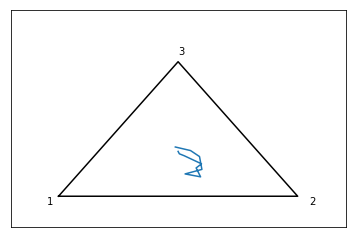

In [78]:
def plotSimplex(points, fig=None, 
                vertexlabels=['1','2','3'],
                **kwargs):
    """
    Plot Nx3 points array on the 3-simplex 
    (with optionally labeled vertices) 
    
    kwargs will be passed along directly to matplotlib.pyplot.plot    
    Returns Figure, caller must .show(), unless in a notebook
    """
    if(fig == None):        
        fig = plt.figure()
    # Draw the triangle
    l1 = mpl.lines.Line2D([0, 0.5, 1.0, 0], # xcoords
                  [0, np.sqrt(3) / 2, 0, 0], # ycoords
                  color='k')
    fig.gca().add_line(l1)
    fig.gca().xaxis.set_major_locator(mpl.ticker.NullLocator())
    fig.gca().yaxis.set_major_locator(mpl.ticker.NullLocator())
    # Draw vertex labels
    fig.gca().text(-0.05, -0.05, vertexlabels[0])
    fig.gca().text(1.05, -0.05, vertexlabels[1])
    fig.gca().text(0.5, np.sqrt(3) / 2 + 0.05, vertexlabels[2])
    # Project and draw the actual points
    projected = projectSimplex(points)
    plt.plot(projected[:,0], projected[:,1], **kwargs)              
    # Leave some buffer around the triangle for vertex labels
    fig.gca().set_xlim(-0.2, 1.2)
    fig.gca().set_ylim(-0.2, 1.2)

    return fig    


def projectSimplex(points):
    """ 
    Project probabilities on the 3-simplex to a 2D triangle
    
    N points are given as N x 3 array
    """
    # Convert points one at a time
    tripts = np.zeros((points.shape[0],2))
    for idx in range(points.shape[0]):
        # Init to triangle centroid
        x = 1.0 / 2
        y = 1.0 / (2 * np.sqrt(3))
        # Vector 1 - bisect out of lower left vertex 
        p1 = points[idx, 0]
        x = x - (1.0 / np.sqrt(3)) * p1 * np.cos(np.pi / 6)
        y = y - (1.0 / np.sqrt(3)) * p1 * np.sin(np.pi / 6)
        # Vector 2 - bisect out of lower right vertex  
        p2 = points[idx, 1]  
        x = x + (1.0 / np.sqrt(3)) * p2 * np.cos(np.pi / 6)
        y = y - (1.0 / np.sqrt(3)) * p2 * np.sin(np.pi / 6)        
        # Vector 3 - bisect out of top vertex
        p3 = points[idx, 2]
        y = y + (1.0 / np.sqrt(3) * p3)
      
        tripts[idx,:] = (x,y)

    return tripts


def random_walk(symmetric_profile, length):
    walk = [symmetric_profile]
    for _ in range(length):
        prof = walk[-1]
        new_prof = prof + np.random.uniform(-.1,.1,prof.shape)
        if(new_prof.min() < 0):
            new_prof -= new_prof.min()
        new_prof /= new_prof.sum()
        walk.append(new_prof)
    return np.array(walk)

profiles = random_walk(uniform_profile(rock_paper_scissors)[0], 10)
print(profiles)
plot = plotSimplex(profiles)

In [97]:
r, trace = replicator_dynamics(rock_paper_scissors, initial_profile=random_profile(rock_paper_scissors), 
                            max_iters=5000,trace=True)

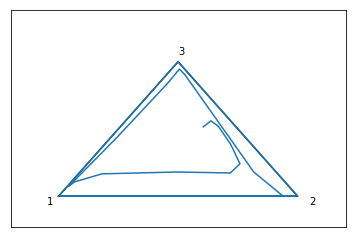

In [98]:
plot = plotSimplex(np.array([strat[0] for strat in trace]))